In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [2]:
df = pd.read_csv("city_day.csv")

In [3]:
df["Date"] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.set_index('Date')
df = df.sort_index()

In [4]:
df.head(), df.shape

(                 City   PM2.5    PM10     NO    NO2     NOx    NH3     CO  \
 Date                                                                        
 2015-01-01  Ahmedabad     NaN     NaN   0.92  18.22   17.15    NaN   0.92   
 2015-01-01    Chennai     NaN     NaN  16.30  15.39   22.68   4.59   1.17   
 2015-01-01      Delhi  313.22  607.98  69.16  36.39  110.59  33.85  15.20   
 2015-01-01    Lucknow     NaN     NaN   2.11  13.46    4.57    NaN  12.15   
 2015-01-01     Mumbai     NaN     NaN    NaN    NaN   27.38    NaN   0.00   
 
                SO2      O3  Benzene  Toluene  Xylene    AQI AQI_Bucket  
 Date                                                                    
 2015-01-01   27.64  133.36     0.00     0.02    0.00    NaN        NaN  
 2015-01-01    9.20   11.35     0.17      NaN     NaN    NaN        NaN  
 2015-01-01    9.25   41.68    14.36    24.86    9.84  472.0     Severe  
 2015-01-01  169.57   25.92     1.35     3.93     NaN    NaN        NaN  
 2015-01

In [5]:
df = df[df["City"] == "Delhi"]
df.head(), df.tail(), df.shape

(             City   PM2.5    PM10     NO    NO2     NOx     NH3     CO   SO2  \
 Date                                                                           
 2015-01-01  Delhi  313.22  607.98  69.16  36.39  110.59   33.85  15.20  9.25   
 2015-01-02  Delhi  186.18  269.55  62.09  32.87   88.14   31.83   9.54  6.65   
 2015-01-03  Delhi   87.18  131.90  25.73  30.31   47.95   69.55  10.61  2.65   
 2015-01-04  Delhi  151.84  241.84  25.01  36.91   48.62  130.36  11.54  4.63   
 2015-01-05  Delhi  146.60  219.13  14.01  34.92   38.25  122.88   9.20  3.33   
 
                O3  Benzene  Toluene  Xylene    AQI AQI_Bucket  
 Date                                                           
 2015-01-01  41.68    14.36    24.86    9.84  472.0     Severe  
 2015-01-02  29.97    10.55    20.09    4.29  454.0     Severe  
 2015-01-03  19.71     3.91    10.23    1.99  143.0   Moderate  
 2015-01-04  25.36     4.26     9.71    3.34  319.0  Very Poor  
 2015-01-05  23.20     2.80     6.21    2

In [6]:
df.isnull().sum() / len(df)

City          0.000000
PM2.5         0.000996
PM10          0.038328
NO            0.000996
NO2           0.000996
NOx           0.000000
NH3           0.004480
CO            0.000000
SO2           0.054754
O3            0.041812
Benzene       0.000000
Toluene       0.000000
Xylene        0.388751
AQI           0.004978
AQI_Bucket    0.004978
dtype: float64

In [7]:
df = df["PM2.5"]

In [8]:
df = df.fillna(method='ffill')

In [9]:
df.describe()

count    2009.000000
mean      117.101215
std        82.926225
min        10.240000
25%        57.080000
50%        94.490000
75%       152.990000
max       685.360000
Name: PM2.5, dtype: float64

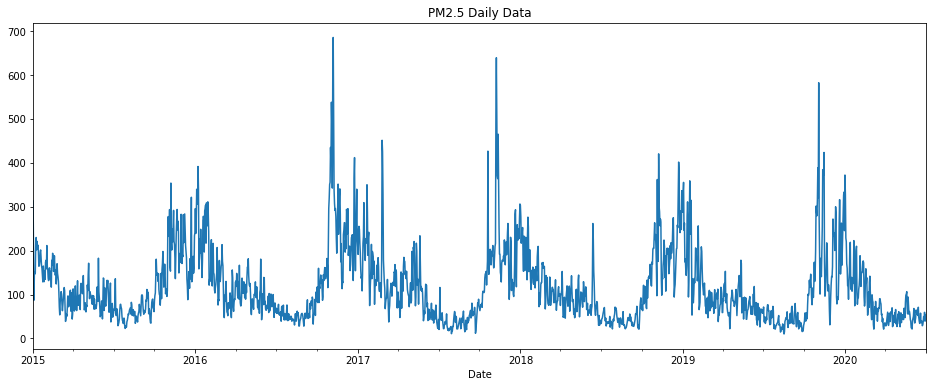

In [10]:
df.plot(figsize=(16, 6))
plt.title(label="PM2.5 Daily Data")
# plt.savefig('images/pm-daily.png')
plt.show()

In [11]:
df_weekly = df.resample('W').mean()

In [12]:
df_weekly.head(), df_weekly.tail(), df_weekly.shape

(Date
 2015-01-04    184.605000
 2015-01-11    196.005714
 2015-01-18    187.650000
 2015-01-25    156.357143
 2015-02-01    162.784286
 Freq: W-SUN, Name: PM2.5, dtype: float64,
 Date
 2020-06-07    46.195714
 2020-06-14    58.957143
 2020-06-21    41.858571
 2020-06-28    41.014286
 2020-07-05    46.223333
 Freq: W-SUN, Name: PM2.5, dtype: float64,
 (288,))

In [14]:
df_weekly.describe()

count    288.000000
mean     117.061036
std       74.533315
min       20.781429
25%       60.671429
50%       93.680000
75%      157.806429
max      495.152857
Name: PM2.5, dtype: float64

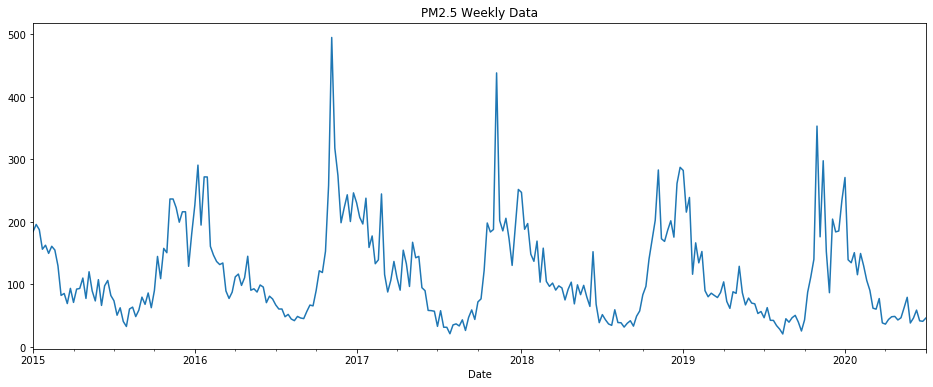

In [13]:
df = df_weekly
df.plot(figsize=(16, 6))
plt.title(label="PM2.5 Weekly Data")
# plt.savefig('images/pm-weekly.png')
plt.show()

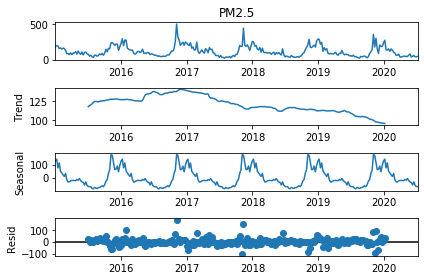

In [32]:
decomposition = seasonal_decompose(df)
decomposition.plot()
plt.savefig('images/pm-decomposition.png')
plt.show()

C:\Users\vishw\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


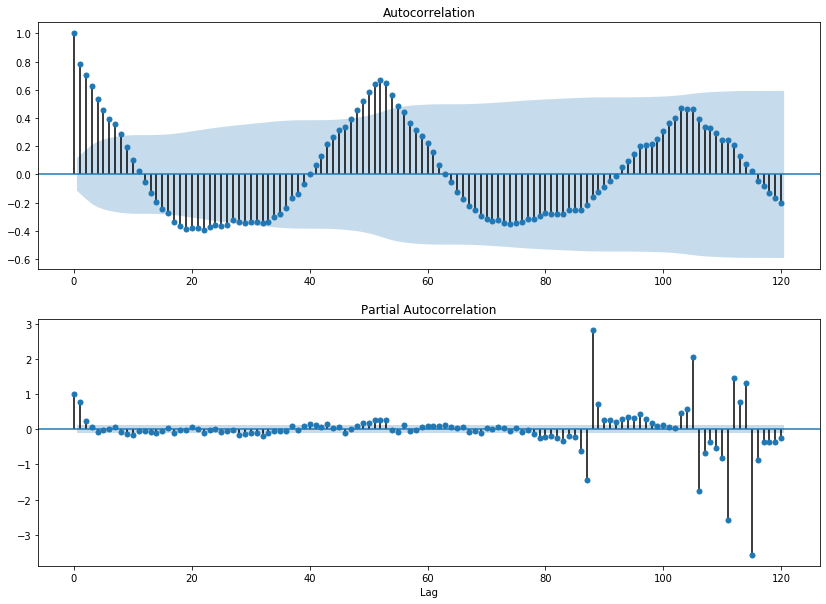

In [33]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,10))
ax1 = plot_acf(df, lags=120, ax=ax1)
ax2 = plot_pacf(df, lags=120, ax=ax2)
# plt.savefig('images/pm-acf-pacf.png')
plt.xlabel("Lag")
plt.show()

In [34]:
dftest = adfuller(df)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -4.597368
p-value                          0.000131
#Lags Used                       9.000000
Number of Observations Used    278.000000
Critical Value (1%)             -3.454094
Critical Value (5%)             -2.871993
Critical Value (10%)            -2.572340
dtype: float64


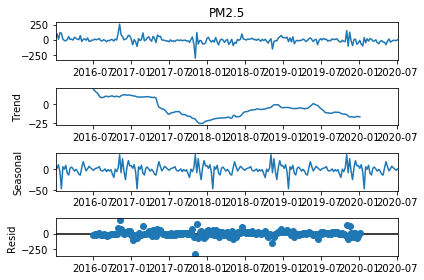

In [35]:
df_52 = df.diff(52).dropna()
decomposition = seasonal_decompose(df_52)
decomposition.plot()
plt.savefig('images/pm-52-lag-decomposition.png')
plt.show()

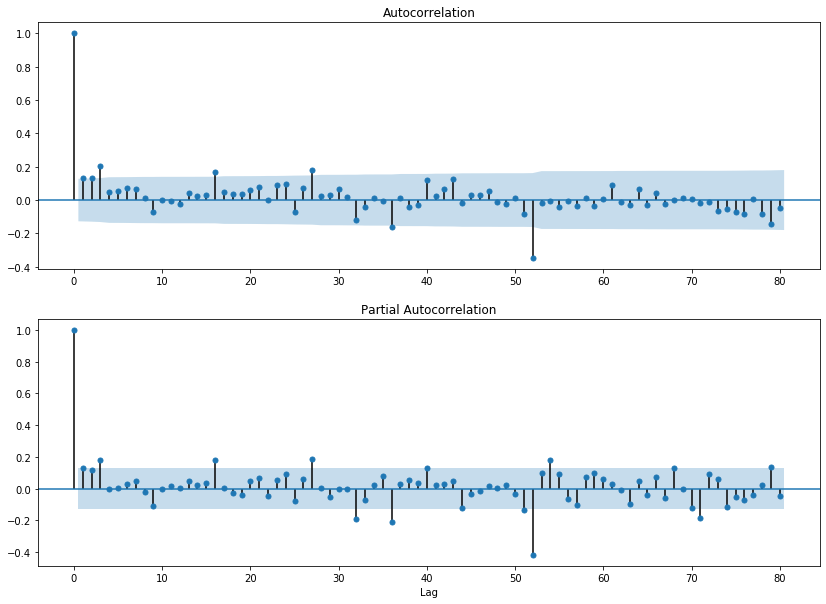

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,10))
ax1 = plot_acf(df_52, lags=80, ax=ax1)
ax2 = plot_pacf(df_52, lags=80, ax=ax2)
# plt.savefig('images/pm-52-lag-acf-pacf.png')
plt.xlabel("Lag")
plt.show()

In [37]:
dftest = adfuller(df_52)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -6.485009e+00
p-value                        1.267289e-08
#Lags Used                     2.000000e+00
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


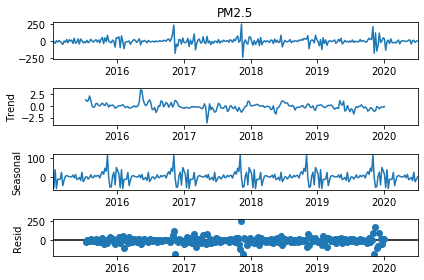

In [38]:
df_1 = df.diff(1).dropna()
decomposition = seasonal_decompose(df_1)
decomposition.plot()
plt.savefig('images/pm-1-lag-decomposition.png')
plt.show()

C:\Users\vishw\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


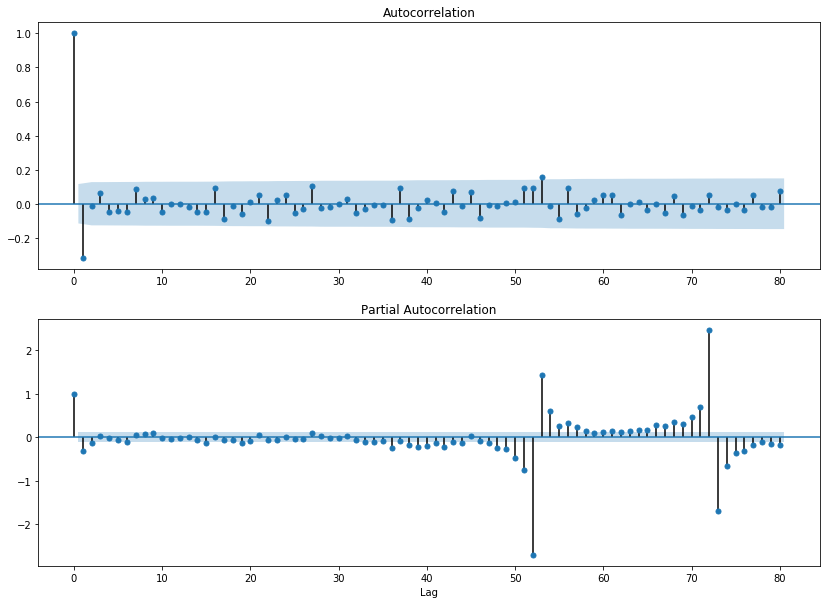

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,10))
ax1 = plot_acf(df_1, lags=80, ax=ax1)
ax2 = plot_pacf(df_1, lags=80, ax=ax2)
# plt.savefig('images/pm-1-lag-acf-pacf.png')
plt.xlabel("Lag")
plt.show()

In [40]:
dftest = adfuller(df_1)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -1.550451e+01
p-value                        2.391967e-28
#Lags Used                     1.000000e+00
Number of Observations Used    2.850000e+02
Critical Value (1%)           -3.453505e+00
Critical Value (5%)           -2.871735e+00
Critical Value (10%)          -2.572202e+00
dtype: float64


In [41]:
# df_weekly.to_csv("df_weekly_pm.csv")